In [1]:
import torch
import numpy as np
from torchvision.datasets import mnist #导入 pytorch内置的mnist数据

from torch import nn
from torch.autograd import Variable

 |文件|内容|
 |--|:--|
 |train-images-idx3-ubyte.gz|训练集图片 - 55000 张 训练图片, 5000 张验证图片|
 |train-labels-idx1-ubyte.gz|训练集图片对应的数字标签|
 |t10k-images-idx3-ubyte.gz|测试集图片 - 10000 张 图片|
 |t10k-labels-idx1-ubyte.gz|测试集图片对应的数字标签|
 
 pytorch下载完会自动解压

In [2]:
#使用内置函数下载mnist数据集
train_set = mnist.MNIST('./data',train=True,download=True)
test_set = mnist.MNIST('./data',train=False,download=True)

In [3]:
a_data, a_label = train_set[0]

In [4]:
a_data

In [5]:
a_label

5

这里读入的数据是PIL库中的格式，可以很方便的将其转换为numpy array

In [6]:
a_data = np.array(a_data,dtype='float32')
print(a_data.shape)

(28, 28)


In [13]:
print(a_data)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

数据展示出来，里面的0表示黑色，255表示白色
对于神经网络，第一层的输入就是28×28=784，所以必须将得到的数据做一个变换，使用reshape将他们拉平成一个一维向量

### 流程：

* 定义数据集
* 定义模型
* 定义loss和优化器
* 训练

In [7]:
def data_tf(x):
    x=np.array(x,dtype='float32')/ 255
    x=(x - 0.5)/ 0.5 
    x=x.reshape((-1,))#拉平
    x=torch.from_numpy(x)
    return x
train_set=mnist.MNIST('./data',train=True,transform=data_tf,download=True)
test_set=mnist.MNIST('./data',train=False,transform=data_tf,download=True)

In [8]:
a,a_label = train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
5


In [9]:
from torch.utils.data import DataLoader
#使用pytorch自带的DataLoder定义一个数据迭代器
train_data = DataLoader(train_set, batch_size=64,shuffle=True)
test_data = DataLoader(test_set,batch_size=128,shuffle=False)

In [10]:
a,a_label = next(iter(train_data))

In [11]:
#打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


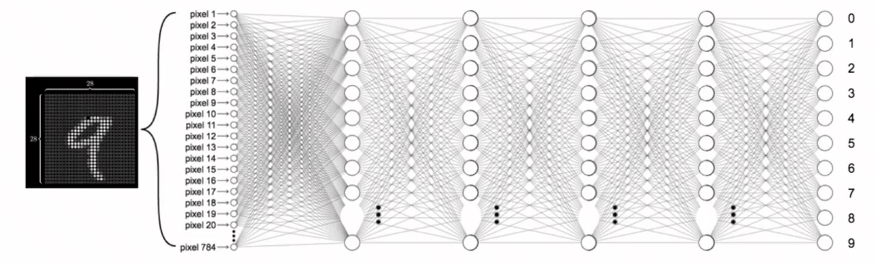

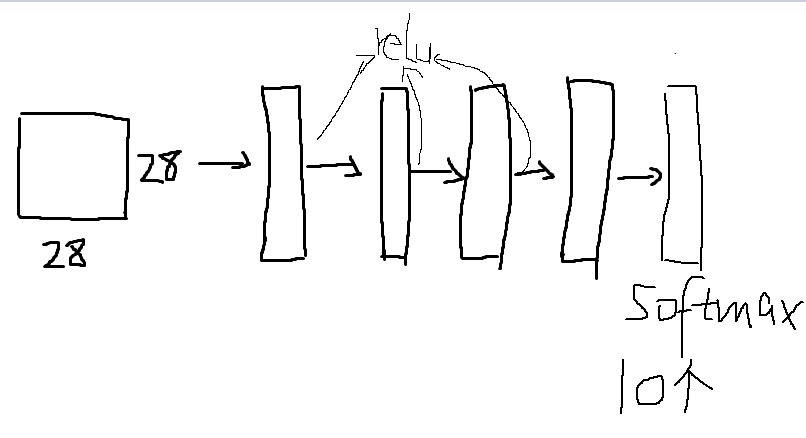

In [12]:
#使用Sequential 定义4层神经网络
net = nn.Sequential(
    nn.Linear(784,400),
    nn.ReLU(),
    nn.Linear(400,200),
    nn.ReLU(),
    nn.Linear(200,100),
    nn.ReLU(),
    nn.Linear(100,10)
)

In [13]:
net

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)

交叉熵在pytorch中已经内置了，交叉熵的数值稳定性更差，所以内置的函数已经帮我们解决了这个问题

In [14]:
#定义loss函数
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),1e-1) #使用随机梯度下降，学习率0.1

In [15]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        #train_loss += loss.data[0] #报错 版本问题
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.524639, Train Acc: 0.830307, Eval Loss: 0.196595, Eval Acc: 0.937896
epoch: 1, Train Loss: 0.169251, Train Acc: 0.947844, Eval Loss: 0.202472, Eval Acc: 0.932555
epoch: 2, Train Loss: 0.118582, Train Acc: 0.962903, Eval Loss: 0.091459, Eval Acc: 0.970332
epoch: 3, Train Loss: 0.090689, Train Acc: 0.971249, Eval Loss: 0.092443, Eval Acc: 0.973299
epoch: 4, Train Loss: 0.074384, Train Acc: 0.976912, Eval Loss: 0.103744, Eval Acc: 0.968948
epoch: 5, Train Loss: 0.062870, Train Acc: 0.979061, Eval Loss: 0.092980, Eval Acc: 0.972211
epoch: 6, Train Loss: 0.052165, Train Acc: 0.983426, Eval Loss: 0.079641, Eval Acc: 0.976167
epoch: 7, Train Loss: 0.045725, Train Acc: 0.985724, Eval Loss: 0.069120, Eval Acc: 0.978639
epoch: 8, Train Loss: 0.036937, Train Acc: 0.987773, Eval Loss: 0.078571, Eval Acc: 0.976365
epoch: 9, Train Loss: 0.031771, Train Acc: 0.989855, Eval Loss: 0.087811, Eval Acc: 0.974090
epoch: 10, Train Loss: 0.028822, Train Acc: 0.990905, Eval Loss: 0.101

画出 loss 曲线和 准确率曲线

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

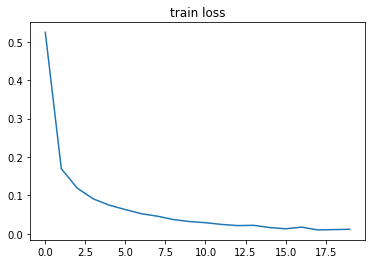

In [17]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)

Text(0.5,1,'train acc')

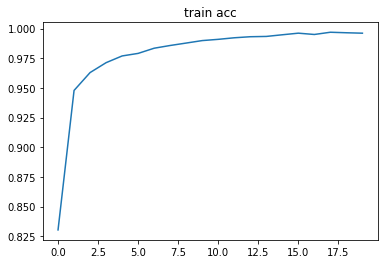

In [18]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')

Text(0.5,1,'test loss')

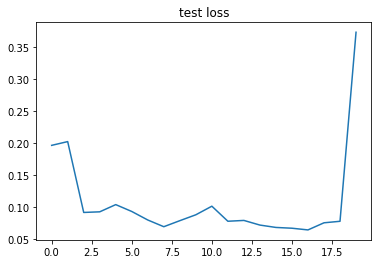

In [19]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')

Text(0.5,1,'test acc')

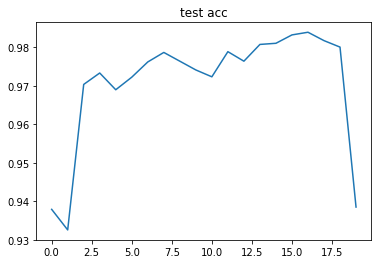

In [20]:
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')

* 三层网络在训练集达到99.9的准确率，测试集上达到98.2的准确率
## 训练集没有出现过拟合现象，但是测试集稍微有点，原因不知道，还是有点问题，可以调节下，batch_size,或者学习率。

## pytorch里集成了许多api函数，各种激活函数(relu,sigmoid等等)，还有它在梯度下降，反向传播中也集成了许多，具体可以去官网查看手册。